Import Libraries

In [11]:
# import statements 
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from IPython.display import display
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import nltk
from sklearn.svm import SVC
import naive_bayes as nb 

Load the dataset for dunkin + display first 5 rows

In [12]:
sb_df = pd.read_csv('dunkin.csv')
sb_df = sb_df.dropna(subset=['label', 'text'])  # remove rows with missing data
sb_df.head()

,text,label
0,why did nobody tell me how good the pistachio ...,positive
1,asking for a tequila soda at dunkin,neutral
2,I was working at a client’s home today and the...,neutral
3,My uber driver is drinking a beer out of a dun...,neutral
4,bought some homemade coffee stuff so i can fin...,negative


Preprocessing Tokenization + 
Text data like tweets are unstructured, containing uppercase letters, punctuation, etc. To prepare the data for logistic regression, which needs numerical input, we will preprocess the tweets into a consistent form by cleaning and tokenizing messages.

**What we've done here:**
  - Converted text to lowercase.
  - Removed punctuation.
  - Tokenized the tweets into a list of words by splitting on each whitespace.
  - Store the token lists in a new 'tokens' column.


In [13]:
# Let's begin by tokenizing each text 

stop_words = stopwords.words('english')
emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                           "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF"
                           "\U00002700-\U000027BF\U0001F900-\U0001F9FF"
                           "\U00002600-\U000026FF\u200d]+", flags=re.UNICODE)

def preprocess_text(text, remove_stopwords=False):
    lowercase = text.lower()
    text = re.sub(r"[^a-z0-9\s" + emoji_pattern.pattern + "]", "", lowercase)
    tokens = text.split()
    if remove_stopwords:
        tokens = [w for w in tokens if w not in stop_words]
    return tokens 

sb_df['tokens'] = sb_df['text'].apply(preprocess_text)
sb_df.head()

,text,label,tokens
0,why did nobody tell me how good the pistachio ...,positive,"[why, did, nobody, tell, me, how, good, the, p..."
1,asking for a tequila soda at dunkin,neutral,"[asking, for, a, tequila, soda, at, dunkin]"
2,I was working at a client’s home today and the...,neutral,"[i, was, working, at, a, client’s, home, today..."
3,My uber driver is drinking a beer out of a dun...,neutral,"[my, uber, driver, is, drinking, a, beer, out,..."
4,bought some homemade coffee stuff so i can fin...,negative,"[bought, some, homemade, coffee, stuff, so, i,..."



To train and evaluate our logistic regression model effectively, we need to split the dataset into training and test sets. The training set will be used to learn model parameters, while the test set will assess performance on unseen data. Additionally, logistic regression requires numerical labels, so we’ll map 'ham' and 'spam' to 0 and 1.


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Split full df
train_df, test_df = train_test_split(sb_df, test_size=0.2, random_state=42, stratify=sb_df['label'])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#to prevent unexpected/missing values
sb_df = sb_df[sb_df['label'].isin(['positive', 'neutral', 'negative'])].copy()


# Step 2: Label encoding
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train = train_df['label'].map(label_map).values
y_test = test_df['label'].map(label_map).values




##Computing TF-IDF Features

Logistic regression needs numerical features, so we will transform our tokenized messages into TF-IDF (Term Frequency-Inverse Document Frequency) vectors. These vectors weight words based on their frequency within a message (TF) and how rare they are across all messages (IDF), and highlight the terms which distinguish between positive, negative, and neutral. This will be limited to the top 1000 words.

In [15]:
from collections import Counter
import numpy as np

# Step 1: Build vocabulary from training set
all_words = []
for tokens in train_df['tokens']:
    all_words.extend(tokens)  # flatten list of tokens

# Count frequencies and select top 1000 words
word_counts = Counter(all_words)
top = word_counts.most_common(1000)
vocab = [word for word, _ in top]

# Create a word-to-index mapping
word_to_idx = {word: i for i, word in enumerate(vocab)}

# Step 2: Compute IDF
df_counts = {word: 0 for word in vocab}
for tokens in train_df['tokens']:
    unique_words = set(tokens)
    for word in unique_words:
        if word in df_counts:
            df_counts[word] += 1

N = len(train_df)
idf = {word: np.log(N / (1 + df_counts[word])) for word in vocab}

# Step 3: TF-IDF computation function
def compute_tfidf(tokens, vocab, word_to_idx, idf):
    tfidf_vector = np.zeros(len(vocab))
    word_count = Counter(tokens)
    for word, count in word_count.items():
        if word in vocab:
            idx = word_to_idx[word]
            tf = count / len(tokens)
            tfidf_vector[idx] = tf * idf[word]
    return tfidf_vector

# Step 4: Create X_train
X_train = np.array([compute_tfidf(tokens, vocab, word_to_idx, idf) for tokens in train_df['tokens']])

# Step 5: Create X_test
X_test = np.array([compute_tfidf(tokens, vocab, word_to_idx, idf) for tokens in test_df['tokens']])

# Step 6: Create y_train and y_test
# Map labels to numbers (if you have 3 classes: 'positive', 'neutral', 'negative')
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train = train_df['label'].map(label_map).values
y_test = test_df['label'].map(label_map).values

# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (432, 1000)
X_test shape: (108, 1000)
y_train shape: (432,)
y_test shape: (108,)


 Define the core functions of logistic regression: the sigmoid function to model probabilities, the cost function to measure error, and the gradient descent to optimize weights. These components form the backbone of the algorithm, allowing it to learn the relationship between TF-IDF features and positive/negative/neutral tweet labels.

 - Add a bias term (column of ones) to `X_train` and `X_test`.
- Implement `sigmoid(z)`: \( \sigma(z) = \frac{1}{1 + e^{-z}} \).
- Implement `compute_cost(X, y, w)` using binary cross-entropy: \( J(w) = -\frac{1}{m} \sum [y_i \log(h(x_i)) + (1-y_i) \log(1-h(x_i))] \).
- Implement `gradient_descent(X, y, w, learning_rate, num_iterations)` to update weights and track cost.

In [16]:
import numpy as np

# Add bias term
X_train_bias = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test_bias = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function
def compute_cost(X, y, w):
    m = len(y)
    z = X.dot(w)
    h = sigmoid(z)
    cost = -1/m * np.sum(y * np.log(h + 1e-8) + (1 - y) * np.log(1 - h + 1e-8))  # Add epsilon to avoid log(0)
    return cost

# Gradient descent
def gradient_descent(X, y, w, learning_rate, num_iterations):
    m = len(y)
    for i in range(num_iterations):
        z = X.dot(w)
        h = sigmoid(z)
        gradient = (1/m) * X.T.dot(h - y)
        w = w - learning_rate * gradient
    return w

# One-vs-rest training
def train_ovr(X, y, num_classes, learning_rate=0.1, num_iterations=1000):
    n_features = X.shape[1]
    all_weights = np.zeros((num_classes, n_features))
    for c in range(num_classes):
        print(f"Training classifier for class {c}")
        y_binary = (y == c).astype(int)
        w = np.zeros(n_features)
        w = gradient_descent(X, y_binary, w, learning_rate, num_iterations)
        all_weights[c] = w
    return all_weights

# Prediction function
def predict_ovr(X, all_weights):
    z = X.dot(all_weights.T)
    probs = sigmoid(z)
    return np.argmax(probs, axis=1)

# Training
num_classes = 3  # Negative, Neutral, Positive
all_weights = train_ovr(X_train_bias, y_train, num_classes)

# Prediction
y_pred = predict_ovr(X_test_bias, all_weights)


Training classifier for class 0
Training classifier for class 1
Training classifier for class 2


## Training the Model without Regularization

Now we can train the model on the training data. The training involves initializing weights and using gradient descent to find the best values which will minimize the cost function. By keep track of the cost over each iteration, we can ensure that the model is learning.


Training classifier for class 0...
Iteration 0: Cost = 0.6924
Iteration 100: Cost = 0.6305
Iteration 200: Cost = 0.5928
Iteration 300: Cost = 0.5695
Iteration 400: Cost = 0.5546
Iteration 500: Cost = 0.5450
Iteration 600: Cost = 0.5385
Iteration 700: Cost = 0.5341
Iteration 800: Cost = 0.5310
Iteration 900: Cost = 0.5288

Training classifier for class 1...
Iteration 0: Cost = 0.6930
Iteration 100: Cost = 0.6820
Iteration 200: Cost = 0.6749
Iteration 300: Cost = 0.6702
Iteration 400: Cost = 0.6669
Iteration 500: Cost = 0.6644
Iteration 600: Cost = 0.6624
Iteration 700: Cost = 0.6608
Iteration 800: Cost = 0.6594
Iteration 900: Cost = 0.6581

Training classifier for class 2...
Iteration 0: Cost = 0.6930
Iteration 100: Cost = 0.6824
Iteration 200: Cost = 0.6757
Iteration 300: Cost = 0.6714
Iteration 400: Cost = 0.6684
Iteration 500: Cost = 0.6663
Iteration 600: Cost = 0.6647
Iteration 700: Cost = 0.6635
Iteration 800: Cost = 0.6624
Iteration 900: Cost = 0.6614


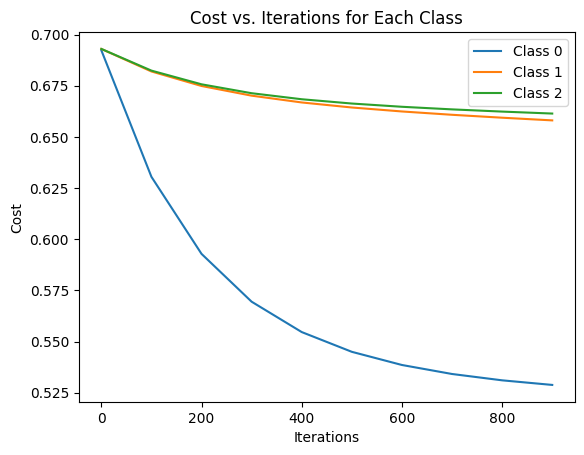

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.01
num_iterations = 1000
num_classes = 3  # Negative, Neutral, Positive

# Initialize all weights and cost history
n_features = X_train_bias.shape[1]
all_weights = np.zeros((num_classes, n_features))
all_costs = []

# Train one classifier per class
for c in range(num_classes):
    print(f"\nTraining classifier for class {c}...")
    
    # Convert labels to binary for one-vs-rest
    y_binary = (y_train == c).astype(int)
    
    # Initialize weights for class c
    w = np.zeros(n_features)
    costs = []

    # Run gradient descent and store costs
    for i in range(num_iterations):
        z = X_train_bias.dot(w)
        h = sigmoid(z)
        gradient = (1 / len(y_binary)) * X_train_bias.T.dot(h - y_binary)
        w -= learning_rate * gradient

        if i % 100 == 0:
            cost = compute_cost(X_train_bias, y_binary, w)
            costs.append(cost)
            print(f"Iteration {i}: Cost = {cost:.4f}")
    
    all_weights[c] = w
    all_costs.append(costs)

# ✅ Plot the cost vs. iterations for each class
for c in range(num_classes):
    plt.plot(range(0, num_iterations, 100), all_costs[c], label=f'Class {c}')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations for Each Class')
plt.legend()
plt.show()


## Making the Predictions
After training, we’ll use the model to predict whether the tweets have positive, negative or neutral sentiment in terms of each brand. This evaluates how well the model generalizes to new data, showing us its usefulness to companies/brands seeking to improve the public's sentiment towards their products, as well as venture capitalists conducting research on companies they'd like to invest in.

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to predict using one-vs-rest classifiers
def predict_multiclass(X, all_weights):
    probabilities = []
    for w in all_weights:
        prob = sigmoid(X.dot(w))
        probabilities.append(prob)
    probabilities = np.array(probabilities)  # shape: (num_classes, num_samples)
    return np.argmax(probabilities, axis=0)  # Choose class with highest probability

# Make predictions
y_pred = predict_multiclass(X_test_bias, all_weights)

print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)
print("Unique values in y_test:", np.unique(y_test))
print("Unique values in y_pred:", np.unique(y_pred))

# Filter out NaNs from y_test and corresponding y_pred
mask = ~np.isnan(y_test)
y_test_clean = y_test[mask]
y_pred_clean = y_pred[mask]

# Evaluate performance
accuracy = accuracy_score(y_test_clean, y_pred_clean)
precision = precision_score(y_test_clean, y_pred_clean, average='macro')
recall = recall_score(y_test_clean, y_pred_clean, average='macro')
f1 = f1_score(y_test_clean, y_pred_clean, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_clean, y_pred_clean))



y_test shape: (108,)
y_pred shape: (108,)
Unique values in y_test: [0 1 2]
Unique values in y_pred: [1 2]
Accuracy: 0.5648
Precision (macro): 0.4619
Recall (macro): 0.4841
F1-score (macro): 0.4219
[[ 0  1 23]
 [ 0 20 22]
 [ 0  1 41]]


/Users/maria/Documents/GitHub/IntroToAI-FinalProj/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Question 8: Implementing L2 Regularization

Regularization prevents overfitting by reducing large weights, and thereby improving generalization. L2 regularization adds a penalty proportional to the squared magnitude of weights, encouraging smaller, more balanced values. Here, you’ll modify the model to include L2 regularization and assess its impact.

- Implemented `compute_cost_L2(X, y, w, lambda_)` with the L2 term: \( \frac{\lambda}{2m} \sum w_j^2 \) (exclude bias).
- Implement `gradient_descent_L2` with the adjusted gradient: \( \frac{\partial J}{\partial w_j} + \frac{\lambda}{m} w_j \) (exclude bias).
- Train with multiple lambda values (e.g., 0.1, 1, 10, 100), plot cost, and evaluate accuracy and weight magnitude.
- Observe how changing lambda affects the model.


Training with lambda = 0.1
Iteration 0: Cost 0.6483
Iteration 100: Cost -0.5294
Iteration 200: Cost -0.8814
Iteration 300: Cost -1.1840
Iteration 400: Cost -1.4775
Iteration 500: Cost -1.7683
Iteration 600: Cost -2.0575
Iteration 700: Cost -2.3453
Iteration 800: Cost -2.6318
Iteration 900: Cost -2.9170
Accuracy with L2 (lambda=0.1): 0.3889
L2 Norm of weights: 4.5650

Training with lambda = 1.0
Iteration 0: Cost 0.6483
Iteration 100: Cost -0.5115
Iteration 200: Cost -0.8352
Iteration 300: Cost -1.0984
Iteration 400: Cost -1.3420
Iteration 500: Cost -1.5731
Iteration 600: Cost -1.7934
Iteration 700: Cost -2.0036
Iteration 800: Cost -2.2044
Iteration 900: Cost -2.3961
Accuracy with L2 (lambda=1.0): 0.3889
L2 Norm of weights: 4.1278

Training with lambda = 10.0
Iteration 0: Cost 0.6484
Iteration 100: Cost -0.3576
Iteration 200: Cost -0.4985
Iteration 300: Cost -0.5611
Iteration 400: Cost -0.5952
Iteration 500: Cost -0.6152
Iteration 600: Cost -0.6273
Iteration 700: Cost -0.6348
Iteration 

/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2336197927.py:15: RuntimeWarning: divide by zero encountered in matmul
  h = sigmoid(X @ w)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2336197927.py:15: RuntimeWarning: overflow encountered in matmul
  h = sigmoid(X @ w)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2336197927.py:15: RuntimeWarning: invalid value encountered in matmul
  h = sigmoid(X @ w)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2336197927.py:39: RuntimeWarning: divide by zero encountered in matmul
  y_pred_L2 = (sigmoid(X_test_bias @ w_trained_L2) >= 0.5).astype(int)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2336197927.py:39: RuntimeWarning: overflow encountered in matmul
  y_pred_L2 = (sigmoid(X_test_bias @ w_trained_L2) >= 0.5).astype(int)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2336197927.py:39: RuntimeWarning: invalid value encountered in 

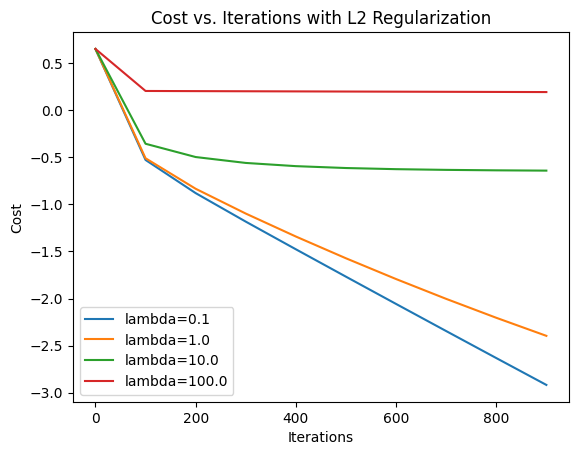

In [19]:
# TODO: Modify compute_cost for L2
def compute_cost_L2(X, y, w, lambda_):
    m = len(y)
    z = X.dot(w)
    h = sigmoid(z)
    cost = - (1/m) * np.sum(y * np.log(h + 1e-15) + (1 - y) * np.log(1 - h + 1e-15))
    cost += (lambda_ / (2 * m)) * np.sum(w[1:]**2)  # exclude bias from regularization
    return cost

# TODO: Modify gradient_descent for L2
def gradient_descent_L2(X, y, w, learning_rate, num_iterations, lambda_):
    m = len(y)
    costs = []
    for i in range(num_iterations):
        h = sigmoid(X @ w)
        gradient = (1/m) * (X.T.dot(h - y))
        gradient[1:] += (lambda_ / m) * w[1:]  # apply L2 penalty only to weights, not bias
        w -= learning_rate * gradient
        if i % 100 == 0:
            cost = compute_cost_L2(X, y, w, lambda_)
            costs.append(cost)
            print(f"Iteration {i}: Cost {cost:.4f}")
    return w, costs

# Test multiple lambda values
lambda_values = [0.1, 1.0, 10.0, 100.0]
learning_rate = 0.1
num_iterations = 1000

for lambda_ in lambda_values:
    print(f"\nTraining with lambda = {lambda_}")
    w = np.zeros(X_train_bias.shape[1])
    w_trained_L2, costs_L2 = gradient_descent_L2(X_train_bias, y_train, w, learning_rate, num_iterations, lambda_)

    # Plot cost
    plt.plot(range(0, num_iterations, 100), costs_L2, label=f'lambda={lambda_}')

    # Predict and evaluate
    y_pred_L2 = (sigmoid(X_test_bias @ w_trained_L2) >= 0.5).astype(int)
    accuracy_L2 = accuracy_score(y_test, y_pred_L2)
    weight_norm = np.linalg.norm(w_trained_L2[:-1])  # exclude bias
    print(f"Accuracy with L2 (lambda={lambda_}): {accuracy_L2:.4f}")
    print(f"L2 Norm of weights: {weight_norm:.4f}")

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations with L2 Regularization')
plt.legend()
plt.show()

# TODO: Comment on how changing lambda affects accuracy and weight magnitude


## Question 9: Implementing L1 Regularization

L1 regularization penalizes the absolute value of weights, promoting sparsity by driving some weights to zero. This can simplify the model by selecting only the most important features, which is useful for interpretability in sentiment analysis of tweets. We will adapt the model for L1 and compare its effects.

- Implement `compute_cost_L1(X, y, w, lambda_)` with the L1 term: \( \frac{\lambda}{m} \sum |w_j| \) (exclude bias).
- Implement `gradient_descent_L1` with the gradient adjustment: \( \frac{\partial J}{\partial w_j} + \frac{\lambda}{m} \text{sign}(w_j) \) (exclude bias).
- Train with multiple lambda values (e.g., 0.1, 1, 10, 100), plot cost, and evaluate accuracy and sparsity.
- Observe how changing lambda affects the model.


Training with lambda = 0.1
Iteration 0: Cost 0.6484
Iteration 100: Cost -0.5268
Iteration 200: Cost -0.8782
Iteration 300: Cost -1.1815
Iteration 400: Cost -1.4770
Iteration 500: Cost -1.7712
Iteration 600: Cost -2.0651
Iteration 700: Cost -2.3590
Iteration 800: Cost -2.6529
Iteration 900: Cost -2.9468
Accuracy with L1 (lambda=0.1): 0.3889
Number of near-zero weights: 169 out of 1000

Training with lambda = 1.0
Iteration 0: Cost 0.6489
Iteration 100: Cost -0.5030
Iteration 200: Cost -0.8367
Iteration 300: Cost -1.1215
Iteration 400: Cost -1.3983
Iteration 500: Cost -1.6736
Iteration 600: Cost -1.9486
Iteration 700: Cost -2.2235
Iteration 800: Cost -2.4985
Iteration 900: Cost -2.7734


/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:15: RuntimeWarning: divide by zero encountered in matmul
  h = sigmoid(X @ w)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:15: RuntimeWarning: overflow encountered in matmul
  h = sigmoid(X @ w)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:15: RuntimeWarning: invalid value encountered in matmul
  h = sigmoid(X @ w)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:39: RuntimeWarning: divide by zero encountered in matmul
  y_pred_L1 = (sigmoid(X_test_bias @ w_trained_L1) >= 0.5).astype(int)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:39: RuntimeWarning: overflow encountered in matmul
  y_pred_L1 = (sigmoid(X_test_bias @ w_trained_L1) >= 0.5).astype(int)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:39: RuntimeWarning: invalid value encountered in 

Accuracy with L1 (lambda=1.0): 0.3889
Number of near-zero weights: 30 out of 1000

Training with lambda = 10.0
Iteration 0: Cost 0.6538


/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:39: RuntimeWarning: divide by zero encountered in matmul
  y_pred_L1 = (sigmoid(X_test_bias @ w_trained_L1) >= 0.5).astype(int)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:39: RuntimeWarning: overflow encountered in matmul
  y_pred_L1 = (sigmoid(X_test_bias @ w_trained_L1) >= 0.5).astype(int)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:39: RuntimeWarning: invalid value encountered in matmul
  y_pred_L1 = (sigmoid(X_test_bias @ w_trained_L1) >= 0.5).astype(int)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:15: RuntimeWarning: divide by zero encountered in matmul
  h = sigmoid(X @ w)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:15: RuntimeWarning: overflow encountered in matmul
  h = sigmoid(X @ w)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py

Iteration 100: Cost -0.3773
Iteration 200: Cost -0.6492
Iteration 300: Cost -0.8680
Iteration 400: Cost -1.0774
Iteration 500: Cost -1.2841
Iteration 600: Cost -1.4911
Iteration 700: Cost -1.6991
Iteration 800: Cost -1.9039
Iteration 900: Cost -2.1101
Accuracy with L1 (lambda=10.0): 0.3889
Number of near-zero weights: 4 out of 1000

Training with lambda = 100.0
Iteration 0: Cost 0.7032
Iteration 100: Cost 2.0437
Iteration 200: Cost 2.4988
Iteration 300: Cost 2.5819
Iteration 400: Cost 2.6445
Iteration 500: Cost 2.6554
Iteration 600: Cost 2.7419
Iteration 700: Cost 2.7846
Iteration 800: Cost 2.7495
Iteration 900: Cost 2.7101
Accuracy with L1 (lambda=100.0): 0.3889
Number of near-zero weights: 1 out of 1000


/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:39: RuntimeWarning: divide by zero encountered in matmul
  y_pred_L1 = (sigmoid(X_test_bias @ w_trained_L1) >= 0.5).astype(int)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:39: RuntimeWarning: overflow encountered in matmul
  y_pred_L1 = (sigmoid(X_test_bias @ w_trained_L1) >= 0.5).astype(int)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:39: RuntimeWarning: invalid value encountered in matmul
  y_pred_L1 = (sigmoid(X_test_bias @ w_trained_L1) >= 0.5).astype(int)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:15: RuntimeWarning: divide by zero encountered in matmul
  h = sigmoid(X @ w)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py:15: RuntimeWarning: overflow encountered in matmul
  h = sigmoid(X @ w)
/var/folders/53/16ljtzy53h7ct9r9bt_3zmj00000gn/T/ipykernel_90468/2820788176.py

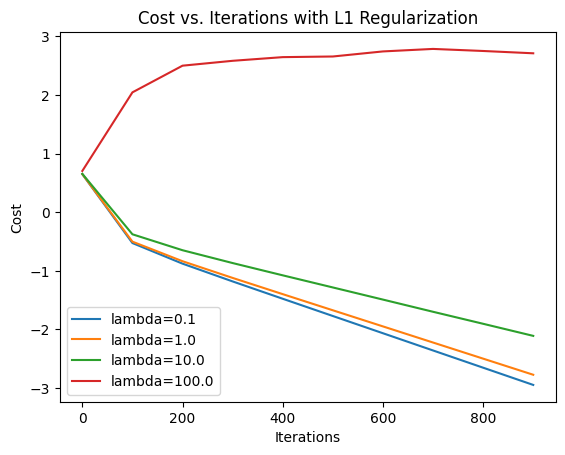

In [20]:
# TODO: Modify compute_cost for L1
def compute_cost_L1(X, y, w, lambda_):
    m = len(y)
    z = X.dot(w)
    h = sigmoid(z)
    cost = - (1/m) * np.sum(y * np.log(h + 1e-15) + (1 - y) * np.log(1 - h + 1e-15))
    cost += (lambda_ / m) * np.sum(np.abs(w[1:]))  # exclude bias
    return cost

# TODO: Modify gradient_descent for L1
def gradient_descent_L1(X, y, w, learning_rate, num_iterations, lambda_):
    m = len(y)
    costs = []
    for i in range(num_iterations):
        h = sigmoid(X @ w)
        gradient = (1/m) * (X.T.dot(h - y))
        gradient[1:] += (lambda_ / m) * np.sign(w[1:])  # L1 uses sign()
        w -= learning_rate * gradient
        if i % 100 == 0:
            cost = compute_cost_L1(X, y, w, lambda_)
            costs.append(cost)
            print(f"Iteration {i}: Cost {cost:.4f}")
    return w, costs

# Test multiple lambda values
lambda_values = [0.1, 1.0, 10.0, 100.0]
learning_rate = 0.1
num_iterations = 1000

for lambda_ in lambda_values:
    print(f"\nTraining with lambda = {lambda_}")
    w = np.zeros(X_train_bias.shape[1])
    w_trained_L1, costs_L1 = gradient_descent_L1(X_train_bias, y_train, w, learning_rate, num_iterations, lambda_)

    # Plot cost
    plt.plot(range(0, num_iterations, 100), costs_L1, label=f'lambda={lambda_}')

    # Predict and evaluate
    y_pred_L1 = (sigmoid(X_test_bias @ w_trained_L1) >= 0.5).astype(int)
    accuracy_L1 = accuracy_score(y_test, y_pred_L1)
    num_zeros = np.sum(np.abs(w_trained_L1[:-1]) < 1e-5)
    print(f"Accuracy with L1 (lambda={lambda_}): {accuracy_L1:.4f}")
    print(f"Number of near-zero weights: {num_zeros} out of {len(w_trained_L1) - 1}")

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations with L1 Regularization')
plt.legend()
plt.show()

# TODO: Comment on how changing lambda affects accuracy and sparsity
